## 统计推断

### 近似推断——随机采样方法

#### 接收-拒绝采样的实践

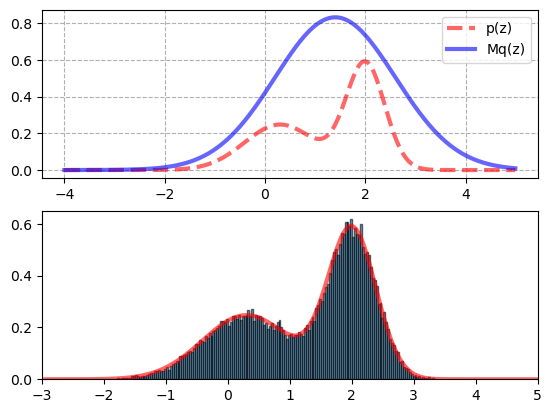

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, norm


# 要采样的目标函数p(z)
def p(z):
    return (0.3 * np.exp(-(z - 0.3) **2) + 0.7 * np.exp(-(z - 2.) ** 2 / 0.3)) / 1.2113

q_norm = norm(loc=1.4, scale=1.2)
uniform_RV = uniform(0, 1)
M = 2.5

fig, ax = plt.subplots(2, 1)

# 先画出两个分布的对比图
z = np.arange(-4., 5, 0.01)
ax[0].plot(z, p(z), color='r', lw=3, alpha=0.6, label='p(z)', linestyle='--')
ax[0].plot(z, M * q_norm.pdf(z), color='b', lw=3, alpha=0.6, label='Mq(z)')
ax[0].grid(ls='--')
ax[0].legend()

# 进行采样
z_samples = []
for i in range(100000):
    z = q_norm.rvs(1)[0]
    uni = uniform_RV.rvs(1)[0]
    
    if p(z) >= uni * M * q_norm.pdf(z):
        z_samples.append(z)
        
x = np.arange(-3., 5, 0.01)
ax[1].set_xlim(-3, 5)
ax[1].plot(x, p(x), color='r', lw=3, alpha=0.6, label='p(x)')
ax[1].hist(z_samples, density=True, bins=200,edgecolor='k', alpha=0.6)

plt.show() # 可以发现这样进行100000次采样，用接收-拒绝法其实效果挺好的，但是从方法上能看出来，基本上很依赖于q(z)和M的选取，Mq(z)越接近p(x)，那效果越好

### 最好的随机采样方法——MCMC法（马尔可夫链——蒙特卡罗法）

#### 基于马尔可夫链的采样

In [17]:
import numpy as np
from scipy.stats import uniform
import random


# 这是一个按照转移矩阵来判断每轮所属马尔可夫链状态的函数，写的很巧妙，可以注意
def randomstate_generator(current_state, trans_MAT):
    uniform_RV = uniform().rvs(1)
    i = current_state - 1
    if uniform_RV[0] <= trans_MAT[i][0]:
        return 1
    elif uniform_RV[0] <= trans_MAT[i][0] + trans_MAT[i][1]:
        return 2
    else:
        return 3
    
trans_MAT = np.array([[0.7, 0.1, 0.2],
                      [0.3, 0.5, 0.2],
                      [0.1, 0.3, 0.6]], dtype='float32')
burn_period = 10000
N_samples = 100000

# 首先random一个随机的初始状态，因为自始自终只有一个“小石子”参与马尔可夫链的状态转移
current_state = random.choice([1, 2, 3])
state_list = []
for i in range(burn_period + N_samples):
    state_list.append(current_state)
    current_state = randomstate_generator(current_state, trans_MAT)
    
state_list = state_list[burn_period:]


for i in range(1, 4):
    print(state_list.count(int(i)) / float(len(state_list)))

0.38638
0.27674
0.33688


### MH采样方法的模拟

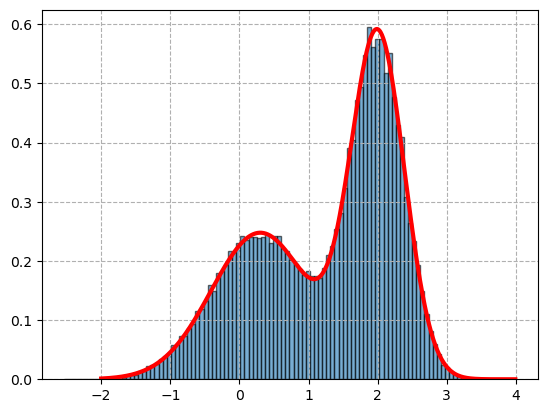

In [5]:
import numpy as np
from scipy.stats import norm
import random
import matplotlib.pyplot as plt


# 要采样的目标函数pi(x)
def pi(x):
    return (0.3 * np.exp(-(x - 0.3) **2) + 0.7 * np.exp(-(x - 2.) ** 2 / 0.3)) / 1.2113

burn_period = 10000
N_samples = 100000
samples = [0 for i in range(burn_period + N_samples)]

# samples[0] = 2 # 选一个状态起点，标准的0也是可以的
# 基于接收概率，进行采样
for j in range(1, burn_period + N_samples): # 因为有初始状态，所以这里采样的次数是少一次的
    x = samples[j - 1]
    x_star = norm.rvs(x, 1, size=1)[0] # 这里是用正态分布来构造了一个转移矩阵Q，这样很方便计算，不过感觉大小就是无限大了......
    # 具体的证明以及构造思路书上有，不过其实这个Q是随便的矩阵都可以的，因为有alpha，所以任意Q均成立
    alpha = min(1, (pi(x_star) / pi(x)))
    u = random.uniform(0, 1)
    
    if u < alpha:
        samples[j] = x_star
    else:
        samples[j] = x
        
X = np.arange(-2, 4, 0.01)
plt.plot(X, pi(X), color='r', lw=3)
plt.hist(samples[burn_period:], bins=100, alpha=0.6, edgecolor='k', density=True)
plt.grid(ls='--')
plt.show()

### MH法的特殊情况——针对高维分布的随机采样法Gibbs法

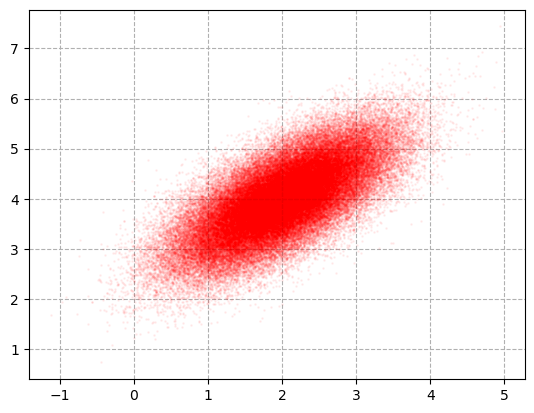

In [13]:
import numpy as np
import matplotlib.pyplot as plt


# 这个采样用二元高斯分布作为例子
# 按照多元高斯分布的先验知识，先写出p(x2|x1)和p(x1|x2)的表达式
def p_x1_given_x2(x2, mu, sigma):
    mu = mu[0] + sigma[0][1] / sigma[1][1] * (x2 - mu[1])
    sigma = sigma[0][0] - sigma[0][1] * sigma[1][0] / sigma[1][1]

    return np.random.normal(mu, sigma)

def p_x2_given_x1(x1, mu, sigma):
    mu = mu[1] + sigma[1][0] / sigma[0][0] * (x1 - mu[0])
    sigma = sigma[1][1] - sigma[1][0] * sigma[0][1] / sigma[0][0]

    return np.random.normal(mu, sigma)

# Gibbs sampling
def Gibbs_sampling(mu, sigma, burn_period, samples_period):
    samples = np.zeros((burn_period + samples_period, 2))
    x2 = np.random.rand() * 10 # 设置初始值
    for i in range(burn_period + samples_period):
        x1 = p_x1_given_x2(x2, mu, sigma)
        x2 = p_x2_given_x1(x1, mu, sigma)
        samples[i, :] = [x1, x2]
    
    return samples

# 输入采样目标分布的信息
mu = np.array([2, 4])
sigma = np.array([[1, .7],
                  [.7, 1]])

# 得到采样点
samples = Gibbs_sampling(mu, sigma, 10000, 100000)[10000:]
plt.plot(samples[:, 0], samples[:, 1], 'ro', alpha=0.05, markersize=1)
plt.grid(ls='--')
plt.show()

# 这里其实和上面的MH方法是一样的，本身Gibbs也就是MH法的一个特例
# 其实中心思想就是，马尔可夫链在达到稳态之后，我们能通过一个巨大的转移次数来模拟多个样本进行蒙特卡洛法的实验
# Gibbs法特殊的地方在于，Gibbs法通过单维度独立取样来实现了对多维度目标函数的随机取样
# 而上面的MH法，因为我们为了计算方便定义了转移函数（矩阵）Q是一个正态函数，所以没有办法对高纬度（2D，3D等）的目标分布进行取样了，因为人家的样本点就已经不是1D的了，我们定义的Q没办法处理
# Gibbs法通过维度单独取样虽然解决了这个问题，但是也有了一定的限制
# 如MH法中定义Q为简单正态分布一样，Gibbs法也需要对每个维度的样本点定义一个转移函数，其实也就是条件概率
# 而由于多维变量的关系，我们不能再将其定义为正态分布这样简单好用的分布了
# 在本例子中，由于我们的目标函数是一个二元高斯分布
# 通过多元高斯分布可以求得x1x2两个变量的条件概率分布表达式，这就代替了MH法中的转移概率函数Q
# 所以Gibbs法的限制条件就是，目标高维分布p的满条件概率分布（也就是一个变量改变，其余变量不变）需要是方便取样的
# 方便取样在本例子里面就是已知分布形式与参数，这样才能成功取样出来
# 如果目标高维分布p的满条件概率是很复杂的形式、没有解析解、不知道服从啥分布，那么Gibbs法就很难完成随机取样了

# 相比MH法，Gibbs法的效率也会更高，因为接受率alpha=1，不会存在拒绝采样的情况